In [1]:
!pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9 MB 18 kB/s 
     |████████████████████████████████| 4.0 MB 10.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.4.0+cu100 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==1.13.0, but you have torch 1.4.0+cu100 which

In [2]:
!pip install robustness

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 3.7 MB/s 
     |████████████████████████████████| 125 kB 55.5 MB/s 
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 182 kB 66.0 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=bb90664828ceb84bc7d32ae99f03b92da02556affa2efb0a432c63084220bbd1
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built GPUtil


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive')

Mounted at /content/drive


In [4]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import matplotlib.pyplot as plt
from robustness import datasets, cifar_models
from robustness.tools.vis_tools import show_image_row
import attacker, utils

In [5]:
HPARAMS = {
  "BATCH_SIZE" : 10,
  "NUM_WORKERS": 1,
  "DATA_AUG": False
}

In [6]:
image_dim = 32
classes = {-1: 'noise',
 0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}
device = torch.device("cuda")

In [7]:
dataset = datasets.CIFAR('/data/')
_, test_loader = dataset.make_loaders(workers= HPARAMS["NUM_WORKERS"], 
                                      batch_size=HPARAMS["BATCH_SIZE"], 
                                      data_aug=HPARAMS["DATA_AUG"])
data_iterator = enumerate(test_loader)

==> Preparing dataset cifar..


0it [00:00, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data/
Files already downloaded and verified


In [8]:
clf = cifar_models.ResNet50(num_classes = 10)
atk = attacker.AttackerModel(clf, dataset)

In [9]:
model = utils.load_model(atk=atk, pt_file="./drive/MyDrive/CIFAR.pt")
model = model.to(device)
model.eval()
pass

Loading checkpoint
Loaded checkpoint at epoch 153


In [15]:
class loss_class:
  def __init__(self):
    pass
  def loss(net,x,target):
      criterion = torch.nn.CrossEntropyLoss(reduction='none')
      return criterion(net(x), target)

In [16]:
images = []
labels = []

for _, (image, label) in enumerate(test_loader):
  images.append(image.to(device))
  labels.append(label.to(device))
  
images = torch.cat(images)
labels = torch.cat(labels)

In [17]:
disitributions = []
for i in range(10):
  mask = labels == i
  masked_images = images[mask] # all images of a certain class
  flat = masked_images.view(len(masked_images),-1).detach().cpu()
  mean = flat.mean(dim=0)
  flat = flat - mean
  covariance = np.matmul(flat.t(),flat)/len(masked_images)
  dist = MultivariateNormal(mean, covariance_matrix=covariance+1e-5*torch.eye(3*32*32))
  disitributions.append(dist)

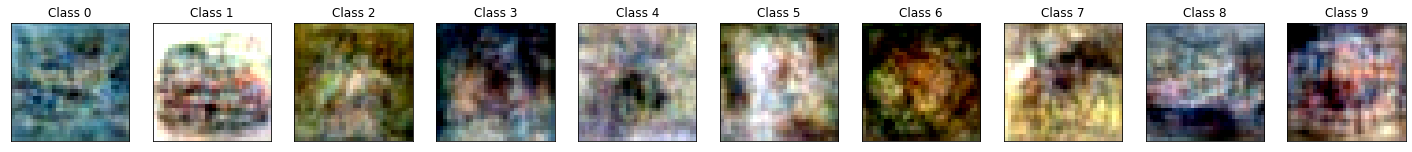

In [18]:
seeds = torch.stack([disitributions[i].sample().reshape(3, image_dim, image_dim) for i in range(10)]).to(device)
seeds = torch.clamp(seeds, min=0, max=1)
show_image_row([seeds.cpu()], tlist=[[f'Class {i}' for i in range(10)]])

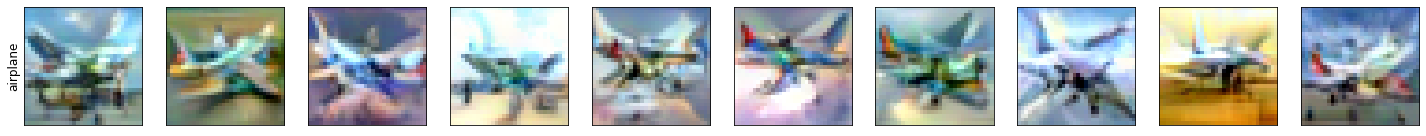

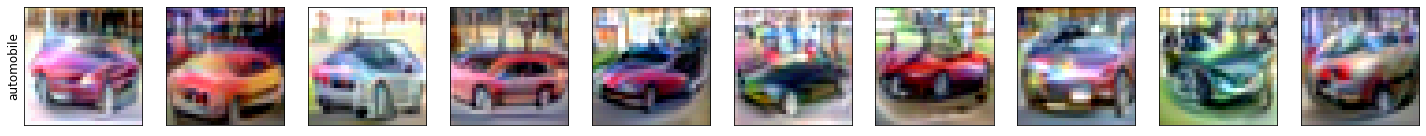

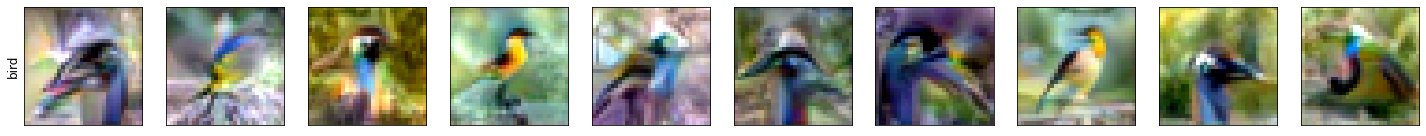

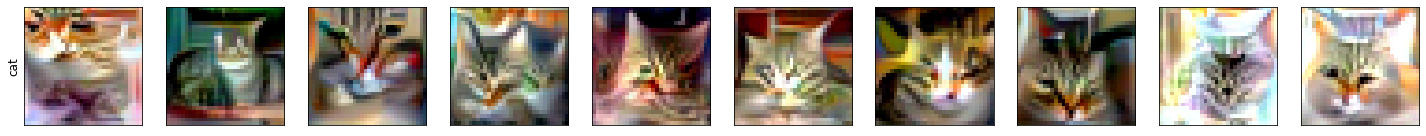

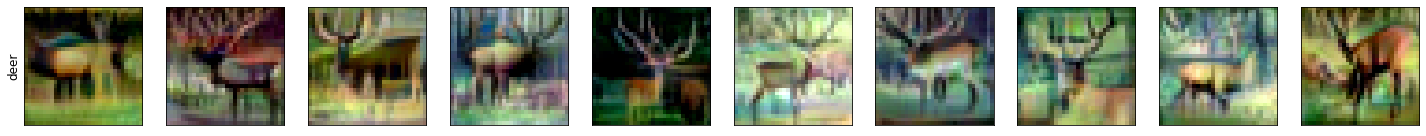

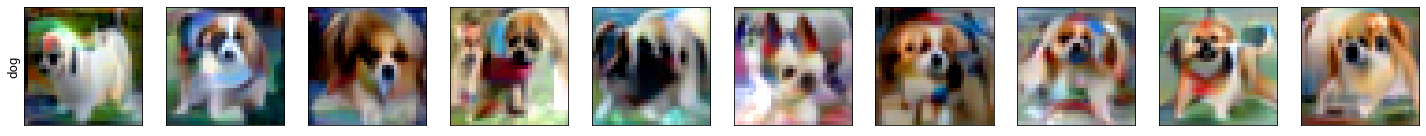

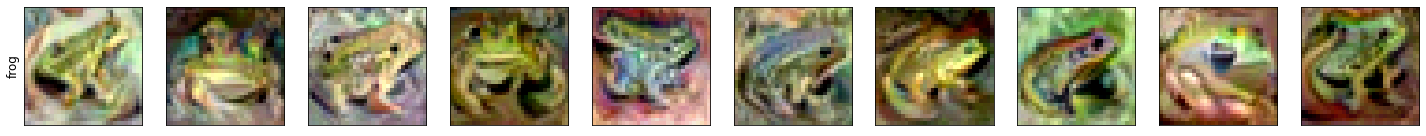

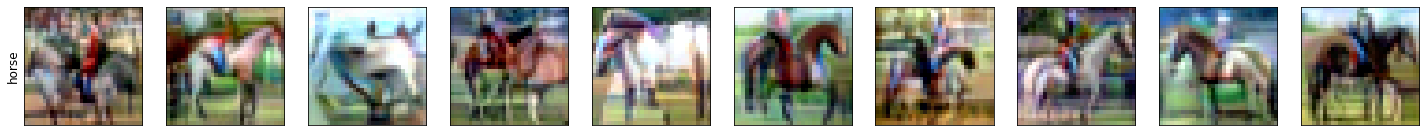

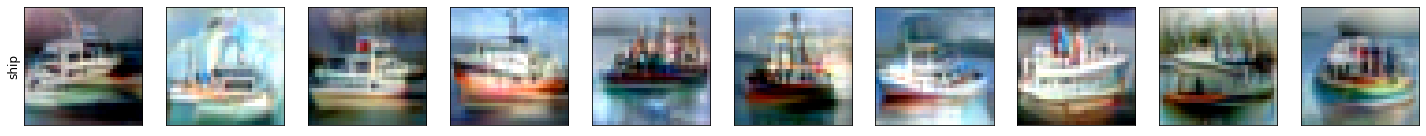

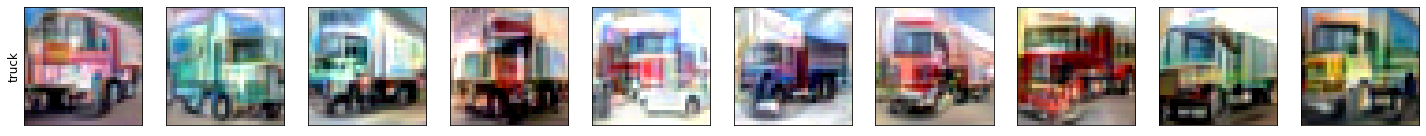

In [19]:
for i in range(10):
    target_class = (i * torch.ones((HPARAMS["BATCH_SIZE"]))).int()
    chosen_seeds = [disitributions[t].sample().reshape(3, image_dim, image_dim) for t in target_class]
    torch_seeds = torch.stack(chosen_seeds)
    _, images = model(torch_seeds.to(device), target_class.long().to(device),eps=80,step_size=.1,iters=100,normalize=True,loss_class = loss_class)
    show_image_row([images.detach().cpu()], [classes[i]])